# Анализ месторождений нефти

## Введение

**Цель проекта**

Разработать решение, которое позволит выбрать регион для разработки с минимальными рисками и максимальной прибылью. 

**Задачи проекта**
1. Разработка модели для прогноза объемов нефти в регионе.
2. Анализ доходности разработки в регионе на основе данных модели.
____

**О данных**

**Датасет geo_data_0** содержит данные геологоразведки для Первого региона. 

**Датасет geo_data_1** содержит данные геологоразведки для Второго региона. 

**Датасет geo_data_2** содержит данные геологоразведки для Третьего региона. 

Все три датасета содержат следующий набор информации:
- id — уникальный идентификатор скважины;
- f0, f1, f2 — признаки скважин;
- product — объём запасов в скважине;
_____

**План проекта**

Для разработки моделей и анализа перспективности разработки будут реализованы следующие шаги.
1. Обзор и предобработка данных
2. Исследовательский анализ данных
3. Корреляционный анализ
4. Обучение моделей прогноза запасов нефти для каждого региона
5. Анализ рисков и прибыли при разработке на основе прогнозов моделей

Далее будет описан общий вывод.

## Импорт библиотек

In [1]:
#импортируем библиотеки для работы

import pandas as pd
import numpy as np
from numpy.random import RandomState

import matplotlib.pyplot as plt
import seaborn as sns

import sys
!{sys.executable} -m pip install phik -q
from phik import phik_matrix

!pip install -U scikit-learn -q

from sklearn.preprocessing import StandardScaler

#from sklearn.compose import ColumnTransformer

from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

RANDOM_STATE = 30

## Функции для работы

In [2]:
#функция для обзора данных
def data_overview(data):
    display(data.head(10))
    print('')
    display(data.sample(10))
    print('')
    display(data.info())
    print('')
    display(data.describe().T)
    print('')
    print('')
    print('Кол-во явных дубликатов:', data.duplicated().sum())
    print('')
    print('Кол-во пропусков:')
    display(data.isna().sum())
    print('')

In [3]:
#функция для обзора неприрывных количественных признаков
def hist_and_box_chart(data, column, title, y_label, x_label, bins):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(f"{title}", fontsize=16)
    palette = ['#87CEEB', '#4682B4', '#1E90FF', 
               '#00BFFF', '#00CED1', '#40E0D0', 
               '#468499', '#B0E0E6', '#66CDAA', '#6495ED']
    
    # Гистограмма
    data[column].plot(
        kind='hist',
        alpha=0.7,
        ax=axes[0],
        color=palette[:len(column)],
        bins=bins
    )
    axes[0].set_xlabel(x_label)
    axes[0].set_ylabel(y_label)
    axes[0].set_title("Гистограмма")

    median = data[column].median()
    mean = data[column].mean()
    axes[0].axvline(median, color='blue', linestyle='dashed', linewidth=2, label=f'Медиана: {median:.2f}')
    axes[0].axvline(mean, color='orange', linestyle='dashed', linewidth=2, label=f'Среднее: {mean:.2f}')
    axes[0].legend()


    # Боксплот
    data[column].plot(
        kind='box',
        ax=axes[1],
        vert=False,
        color={'boxes': 'DarkBlue', 'whiskers': 'gray', 'medians': 'red', 'caps': 'black'}
    )
    axes[1].set_xlabel(x_label)
    axes[1].set_yticklabels([])
    axes[1].set_ylabel('')
    axes[1].set_title("Диаграмма размаха")

    plt.tight_layout()
    plt.show()


In [4]:
#функция для создания выборок для обучения и проверки модели
def train_val_selector(data):
    X = data.drop(['id', 'product'], axis=1)
    y = data['product']
    X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=RANDOM_STATE)
    print('Размеренность тренеровочного и валидационного датасетов с входными признаками:{} и {}'.format(X_train.shape, X_val.shape))
    print('Длина соответствующих столбцов с целевым значением: {} и {}'.format(len(y_train), len(y_val)))
    return X_train, X_val, y_train, y_val

In [5]:
#функиция для обучения моделей линейной регрессии для регионов
def linear_model_prediction(X_train, X_val, y_train, y_val):
    numeric_names = ['f0', 'f1', 'f2']
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train[numeric_names])
    X_val_scaled = scaler.transform(X_val[numeric_names])
    X_train_scaled_pd = pd.DataFrame(X_train_scaled, columns=numeric_names)
    X_val_scaled_pd = pd.DataFrame(X_val_scaled, columns=numeric_names)
    
    model = LinearRegression()
    model.fit(X_train_scaled_pd, y_train)
    prediction = model.predict(X_val_scaled_pd)
    
    rmse = root_mean_squared_error(y_val, prediction)
    
    print('Корень из средней квадратичной ошибки для модели', round(rmse, 2))
    print('')
    print('Среднее значение предсказанного объема запаса нефти в регионе:', round(prediction.mean(), 2))

    return prediction

In [6]:
def profit_calculator(data):
    data = data.sort_values(by='product_prediction', ascending = False)
    data_top_200 = data.head(POINTS_TO_CHOOSE)
    product_sum = data_top_200['product'].sum()
    profit = (product_sum * PRICE_PER_1K) - BUDGET
    return profit

In [7]:
def profit_variations(data):
    profit_variations = []
    for i in range(1000):
        sample = data.sample(n=POINTS_TO_RESEARCH, replace=True, random_state=i)
        profit = profit_calculator(sample)
        profit_variations.append(profit)

    profit_variations = pd.Series(profit_variations)
    profit_mean = profit_variations.mean()

    print('Среднее значение доходности при разработке топ-200 из 500 скважин в регионе:', round(profit_mean, 2))

    profit_lower = profit_variations.quantile(0.025)
    profit_upper = profit_variations.quantile(0.975)
    print('95% доверительный интервал: ({:.2f}, {:.2f})'.format(round(profit_lower, 2), round(profit_upper, 2)))

    loss_probability = (profit_variations < 0).mean()
                           
    if loss_probability < MAX_LOSS:
        print('Вероятность убытков равна {}, что меньше чем максимальная допустимая вероятность {}'.format(loss_probability, MAX_LOSS))
    else:
        print('Вероятность убытков равна {}, что больше чем максимальная допустимая вероятность {}'.format(loss_probability, MAX_LOSS))

    return profit_mean, profit_lower, profit_upper, loss_probability


## Предобработка данных

### Импорт и обзор данных

In [8]:
#импортируем данные по первому региону
try:
    reg_1 = pd.read_csv('Desktop/practicum cases/geo_data_0.csv')
except:
    reg_1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv')

#импортируем данные по второму региону
try:
    reg_2 = pd.read_csv('Desktop/practicum cases/geo_data_1.csv')
except:
    reg_2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv')

#импортируем данные по третьему региону
try:
    reg_3 = pd.read_csv('Desktop/practicum cases/geo_data_2.csv')
except:
    reg_3 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv')

In [9]:
#проверим первый датасет
data_overview(reg_1)

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
5,wX4Hy,0.969570,0.489775,-0.735383,64.741541
6,tL6pL,0.645075,0.530656,1.780266,49.055285
7,BYPU6,-0.400648,0.808337,-5.624670,72.943292
8,j9Oui,0.643105,-0.551583,2.372141,113.356160
9,OLuZU,2.173381,0.563698,9.441852,127.910945


,id,f0,f1,f2,product
62482,FKso2,0.847091,0.708580,0.372060,30.686677
43325,QKPLK,0.526580,-0.568332,-5.230191,45.085859
28399,JTyws,0.955793,0.498162,4.070473,30.041356
23709,0Q83e,0.899217,0.376549,2.716309,14.902660
73034,lV8zd,0.015602,0.850411,2.687335,51.775106
36280,KQdVq,-0.329055,0.970886,-3.212581,16.164591
23044,vyFcT,1.778686,-0.294826,3.519821,30.109400
52209,pToeR,0.584523,0.773873,-2.630740,118.504278
13541,J3wIW,0.208568,0.236023,-0.126302,38.946973
70043,JWBhl,0.885154,0.105498,-0.921341,63.022351



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.500419,0.871832,-1.408605,-0.072580,0.502360,1.073581,2.362331
f1,100000.0,0.250143,0.504433,-0.848218,-0.200881,0.250252,0.700646,1.343769
f2,100000.0,2.502647,3.248248,-12.088328,0.287748,2.515969,4.715088,16.003790
product,100000.0,92.500000,44.288691,0.000000,56.497507,91.849972,128.564089,185.364347




Кол-во явных дубликатов: 0

Кол-во пропусков:


id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

In [10]:
#проверим первый датасет
data_overview(reg_2)

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
5,HHckp,-3.327590,-2.205276,3.003647,84.038886
6,h5Ujo,-11.142655,-10.133399,4.002382,110.992147
7,muH9x,4.234715,-0.001354,2.004588,53.906522
8,YiRkx,13.355129,-0.332068,4.998647,134.766305
9,jG6Gi,1.069227,-11.025667,4.997844,137.945408


,id,f0,f1,f2,product
53094,XRKWp,18.182165,-11.061580,2.994630,80.859783
5735,rLkyE,-1.836065,-12.107046,3.000098,84.038886
11220,053BL,-1.618825,-2.067075,2.989964,84.038886
65222,9V0cl,3.838010,-7.747641,1.001634,26.953261
34722,oqNSm,11.917605,-13.305740,-0.010807,0.000000
18025,yPKHL,-3.945142,-10.489382,5.001145,137.945408
52423,pLv1u,10.593312,-6.768400,4.002644,107.813044
28857,jgmdO,-8.046026,-2.422625,5.003153,137.945408
50811,RfuLd,16.579319,-5.983083,1.004756,26.953261
24879,PRrtm,-1.987143,-3.261973,4.003177,110.992147



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,count,mean,std,min,25%,50%,75%,max
f0,100000.0,1.141296,8.965932,-31.609576,-6.298551,1.153055,8.621015,29.421755
f1,100000.0,-4.796579,5.119872,-26.358598,-8.267985,-4.813172,-1.332816,18.734063
f2,100000.0,2.494541,1.703572,-0.018144,1.000021,2.011479,3.999904,5.019721
product,100000.0,68.825000,45.944423,0.000000,26.953261,57.085625,107.813044,137.945408




Кол-во явных дубликатов: 0

Кол-во пропусков:


id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

In [11]:
#проверим первый датасет
data_overview(reg_3)

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746
5,LzZXx,-0.758092,0.710691,2.585887,90.222465
6,WBHRv,-0.574891,0.317727,1.773745,45.641478
7,XO8fn,-1.906649,-2.458350,-0.177097,72.480640
8,ybmQ5,1.776292,-0.279356,3.004156,106.616832
9,OilcN,-1.214452,-0.439314,5.922514,52.954532


,id,f0,f1,f2,product
81071,Nt1qN,0.534742,-0.383737,-1.878697,88.824358
43757,hIetO,1.542797,1.814092,1.794594,104.504448
50700,EPAgt,-0.323589,-2.750097,2.585085,140.580555
98642,1yIHX,0.047146,-2.848877,4.139105,57.754496
26826,J3kTS,1.864559,0.913133,3.553896,46.415265
54106,nz225,2.263245,-1.115323,4.746011,134.169293
68091,Dhw8M,1.728038,3.070094,3.410508,159.306380
19975,mgkQE,0.533485,-0.022556,-1.204492,67.374865
42976,0VAGH,-1.235894,-1.439600,1.918512,159.311325
2518,FT6bV,-1.837419,1.509121,0.450605,144.207981



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.002023,1.732045,-8.760004,-1.162288,0.009424,1.158535,7.238262
f1,100000.0,-0.002081,1.730417,-7.084020,-1.174820,-0.009482,1.163678,7.844801
f2,100000.0,2.495128,3.473445,-11.970335,0.130359,2.484236,4.858794,16.739402
product,100000.0,95.000000,44.749921,0.000000,59.450441,94.925613,130.595027,190.029838




Кол-во явных дубликатов: 0

Кол-во пропусков:


id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

**Итог обзора данных**

**reg_1**: данные по скважинам первого региона

- Названия столбцов ок.
- Тип данных верный.
- Пропущенных значений нет.
- Основные статистики выглядят адекватно, насколько возможно судить по цифрам без контекста.
- Явных дубликатов нет, но надо проверить неявные дубликаты в столбце id.
______

**reg_2**: данные по скважинам второго региона

- Названия столбцов ок.
- Тип данных верный.
- Пропущенных значений нет.
- Основные статистики выглядят сильно отличающимися от первого и третьего региона.
- Явных дубликатов нет, но надо проверить неявные дубликаты в столбце id.
______

**reg_3**: данные по скважинам третьего региона

- Названия столбцов ок.
- Тип данных верный.
- Пропущенных значений нет.
- Основные статистики выглядят адекватно, насколько возможно судить по цифрам без контекста.
- Явных дубликатов нет, но надо проверить неявные дубликаты в столбце id.

### Проверка на неявные дубликаты

In [12]:
#проверим число уникальных id в первом регионе, чтобы выявить неявные дубликаты
reg_1['id'].nunique()

99990

In [13]:
reg_1['id'].value_counts().head(10)

74z30    2
bxg6G    2
HZww2    2
fiKDv    2
Tdehs    2
A5aEY    2
TtcGQ    2
AGS9W    2
QcMuo    2
bsk9y    2
Name: id, dtype: int64

In [14]:
reg_1[reg_1['id'].map(reg_1['id'].value_counts()) == 2].sort_values(by='id')

,id,f0,f1,f2,product
66136,74z30,1.084962,-0.312358,6.990771,127.643327
64022,74z30,0.741456,0.459229,5.153109,140.771492
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
931,HZww2,0.755284,0.368511,1.863211,30.681774
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502


- Дубли id в датасете первого региона расположены хаотично относительно друг друга и не имеют ни чего общего с друг другом, а равно и аномального сами по себе.
- Возможная причина дублей - сбой или человеческая ошибка.
- Столбец с id нам не понадобится для рассчетов, а сами строки выглядят пригодными, поэтому оставим всё как есть.

In [15]:
#проверим число уникальных id во втором регионе, чтобы выявить неявные дубликаты
reg_2['id'].nunique()

99996

In [16]:
reg_2['id'].value_counts().head(10)

bfPNe    2
5ltQ6    2
LHZR0    2
wt4Uk    2
YY7vq    1
JczBL    1
aPy8f    1
tae07    1
qHQUO    1
Z0QTR    1
Name: id, dtype: int64

In [17]:
reg_2[reg_2['id'].map(reg_2['id'].value_counts()) == 2].sort_values(by='id')

,id,f0,f1,f2,product
5849,5ltQ6,-3.435401,-12.296043,1.999796,57.085625
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044
1305,LHZR0,11.170835,-1.945066,3.002872,80.859783
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
2721,bfPNe,-9.494442,-5.463692,4.006042,110.992147
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886
47591,wt4Uk,-9.091098,-8.109279,-0.002314,3.179103
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305


- Ситуация та же, что и с датасетом в первом регионе.
- Поступим так же - оставим всё, как есть.

In [18]:
#проверим число уникальных id в третьем регионе, чтобы выявить неявные дубликаты
reg_3['id'].nunique()

99996

In [19]:
reg_3['id'].value_counts().head(10)

xCHr8    2
KUPhW    2
VF7Jo    2
Vcm5J    2
AQF9d    1
4JGQt    1
Bu9wj    1
X6t6l    1
ZnVQM    1
WA0Ri    1
Name: id, dtype: int64

In [20]:
reg_3[reg_3['id'].map(reg_3['id'].value_counts()) == 2].sort_values(by='id')

,id,f0,f1,f2,product
45404,KUPhW,0.231846,-1.698941,4.990775,11.716299
55967,KUPhW,1.211150,3.176408,5.543540,132.831802
11449,VF7Jo,2.122656,-0.858275,5.746001,181.716817
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420
44378,Vcm5J,-1.229484,-2.439204,1.222909,137.968290
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572
28039,xCHr8,1.633027,0.368135,-2.378367,6.120525
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641


- Ситуация та же, что и с датасетом в первом регионе.
- Поступим так же - оставим всё, как есть.

### Выводы по предобработке данных 

**reg_1**: данные по скважинам первого региона

- Названия столбцов ок.
- Тип данных верный.
- Пропущенных значений нет.
- Основные статистики выглядят адекватно, насколько возможно судить по цифрам без контекста.
- Явных дубликатов нет.
- Дубликаты в столбце id есть в кол-ве 10 штук, но обусловлены ошибкой. Сами строки-дубликаты выглядят нормально и не схожи между собой, поэтому ошибка вероятнее всего в id. Т.к. id использоваться не будет, строки оставили.
______

**reg_2**: данные по скважинам второго региона

- Названия столбцов ок.
- Тип данных верный.
- Пропущенных значений нет.
- Основные статистики выглядят сильно отличающимися от первого и третьего региона.
- Явных дубликатов нет.
- Дубликаты в столбце id есть в кол-ве 4 штук, но обусловлены ошибкой. Сами строки-дубликаты выглядят нормально и не схожи между собой, поэтому ошибка вероятнее всего в id. Т.к. id использоваться не будет, строки оставили.
______

**reg_3**: данные по скважинам третьего региона

- Названия столбцов ок.
- Тип данных верный.
- Пропущенных значений нет.
- Основные статистики выглядят адекватно, насколько возможно судить по цифрам без контекста.
- Явных дубликатов нет.
- Дубликаты в столбце id есть в кол-ве 4 штук, но обусловлены ошибкой. Сами строки-дубликаты выглядят нормально и не схожи между собой, поэтому ошибка вероятнее всего в id. Т.к. id использоваться не будет, строки оставили.

##  Исследовательский анализ данных

- Т.к. у нас нет понимания сути признаков и какого-либо контекста, мы будем проводить визуальный анализ не по регионам, а по признакам - чтобы иметь хоть какой-то контекст и представление о норме.
- Строить будем отдельные графики, чтобы они оставались читаемыми, несмотря на разные формы распределений из-за разницы диапазонов (см. статистики).

### Анализ признака f0

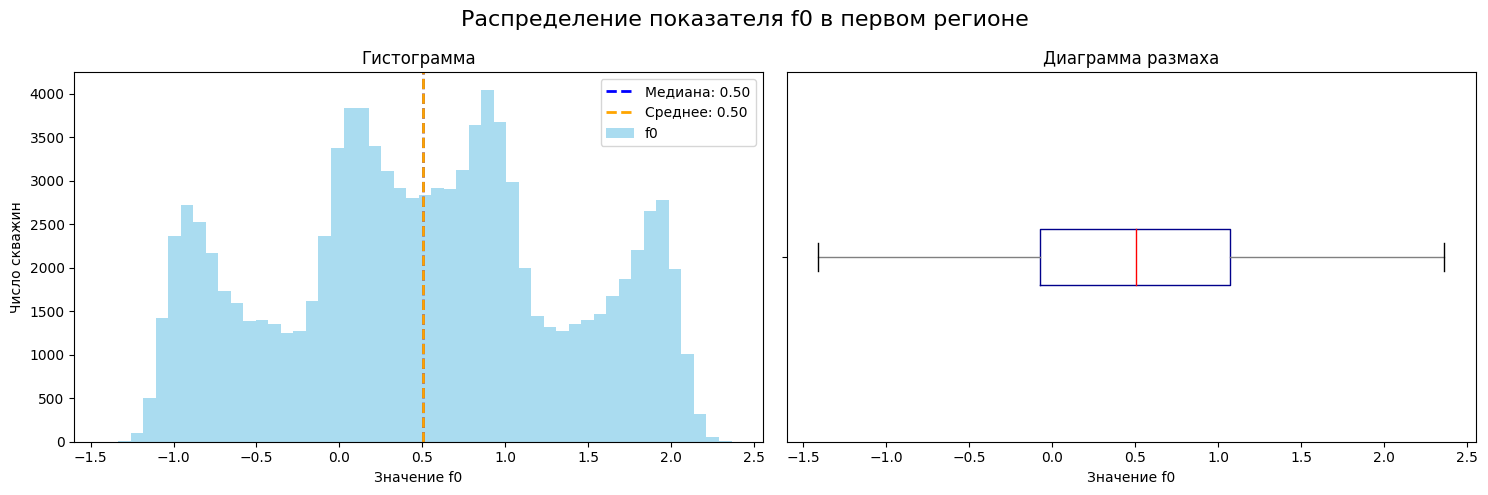

In [21]:
hist_and_box_chart(reg_1, 'f0', 'Распределение показателя f0 в первом регионе', 'Число скважин', 'Значение f0', 50)

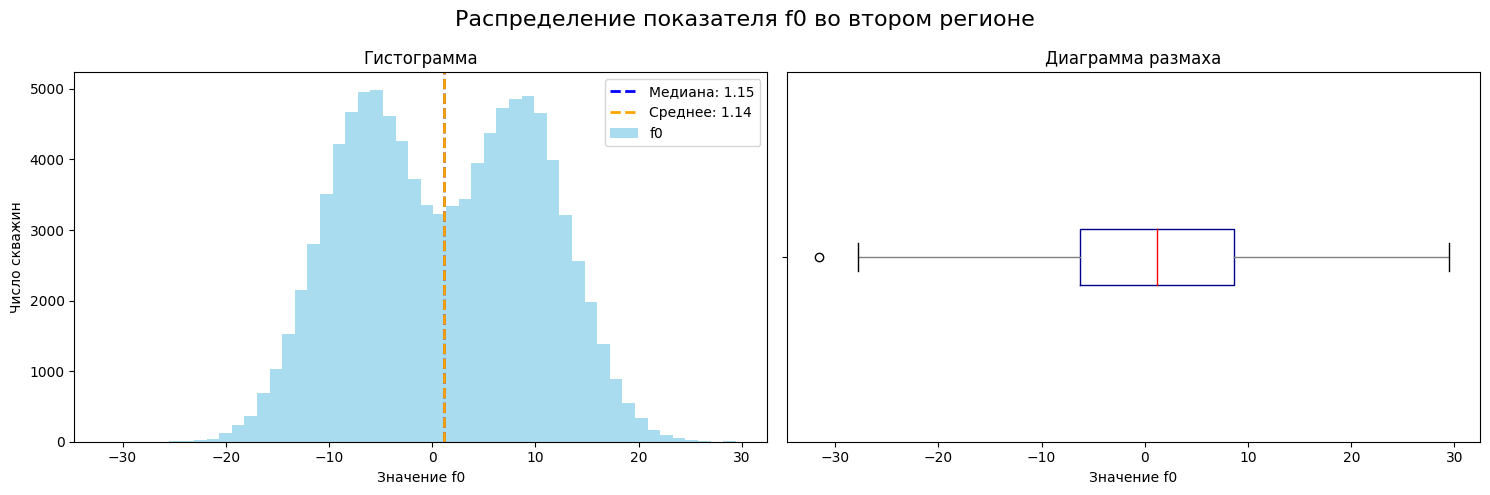

In [22]:
hist_and_box_chart(reg_2, 'f0', 'Распределение показателя f0 во втором регионе', 'Число скважин', 'Значение f0', 50)

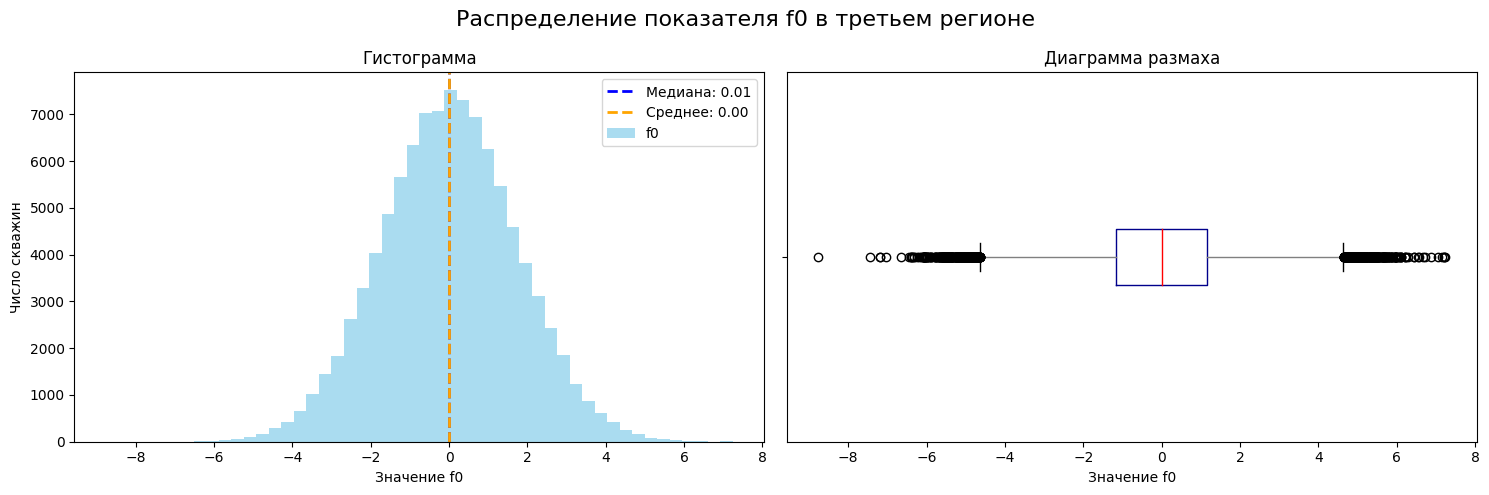

In [23]:
hist_and_box_chart(reg_3, 'f0', 'Распределение показателя f0 в третьем регионе', 'Число скважин', 'Значение f0', 50)

- Все три распределения разные: по форме и диапазонам, хотя при этом имеют схожие средние значения - 0.5, 1.15 и 0.
- Распределение данных в регионе один имеет два больших пика ближе к центру гистограммы и два поменьше по краям. При этом общий диапазон самый компактный, от -1.5 до 2.5.
- Распределение данных в во втором регионе имеет два пика вокруг небольшого провала в области среднего, а по краям плавно нисходит от двух пиков. Очень большой диапазон значений от -30 до 30. Имееются единичные выбросы в области очень низких значений.
- Распределение данных в третьем регионе имеет форму, похожую на нормальное распределение. Диапазон умеренный, от -8 до 8. Имеется большое число выбросов в обе стороны, но ввиду их количества и контекста данных во втором регионе, скорее всего значения более чем ок.

### Анализ признака f1

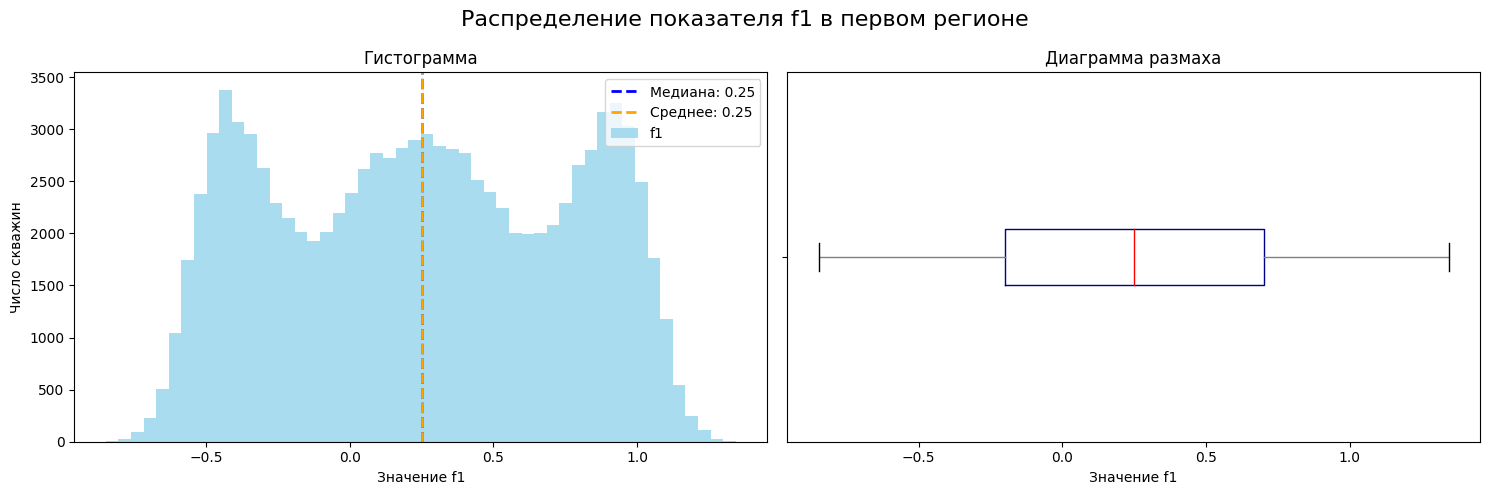

In [24]:
hist_and_box_chart(reg_1, 'f1', 'Распределение показателя f1 в первом регионе', 'Число скважин', 'Значение f1', 50)

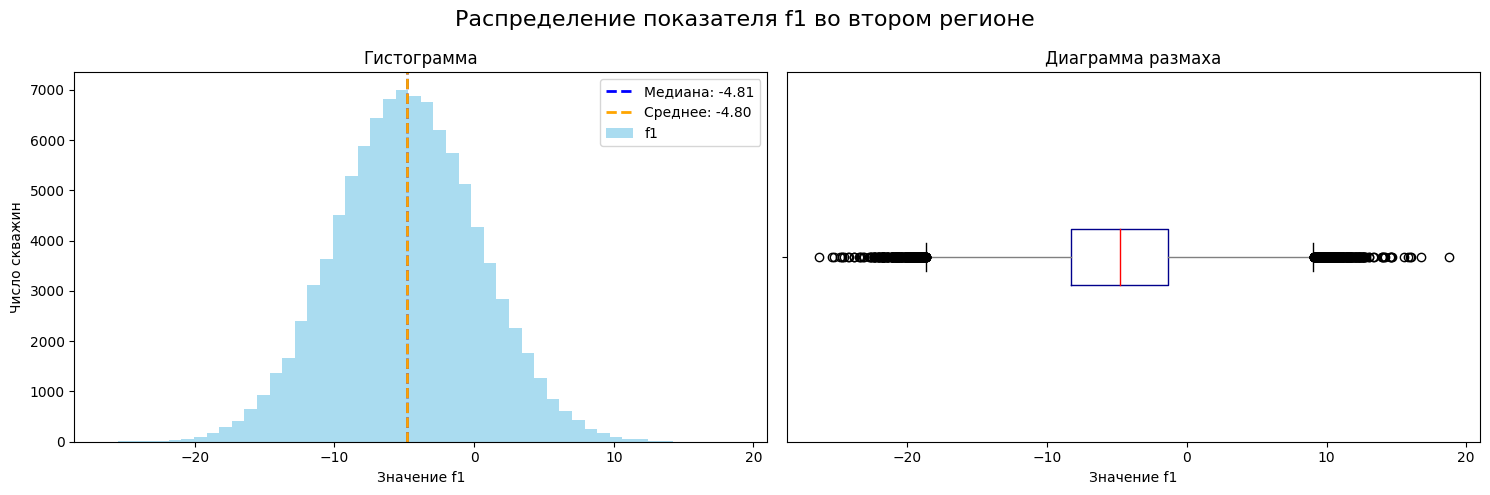

In [25]:
hist_and_box_chart(reg_2, 'f1', 'Распределение показателя f1 во втором регионе', 'Число скважин', 'Значение f1', 50)

In [26]:
reg_2.query('(f1 < -18) | (f1 > 9)')

,id,f0,f1,f2,product
41,GrqpD,-4.758592,-18.409826,3.007507,84.038886
192,GxTGL,6.873130,9.546176,3.998873,107.813044
252,IfDKr,8.105284,10.427709,1.001737,26.953261
304,6QCCp,1.361165,10.031704,1.001664,26.953261
512,9HrqR,-1.887944,9.327144,4.004213,110.992147
...,...,...,...,...,...
99250,HUG7q,-11.310991,-22.335672,4.003400,110.992147
99336,oJRv2,-2.898923,-18.485769,-0.000160,3.179103
99349,DDFNm,-4.506281,11.551203,5.001728,137.945408
99469,uT90b,-4.195565,-18.547602,4.004528,110.992147


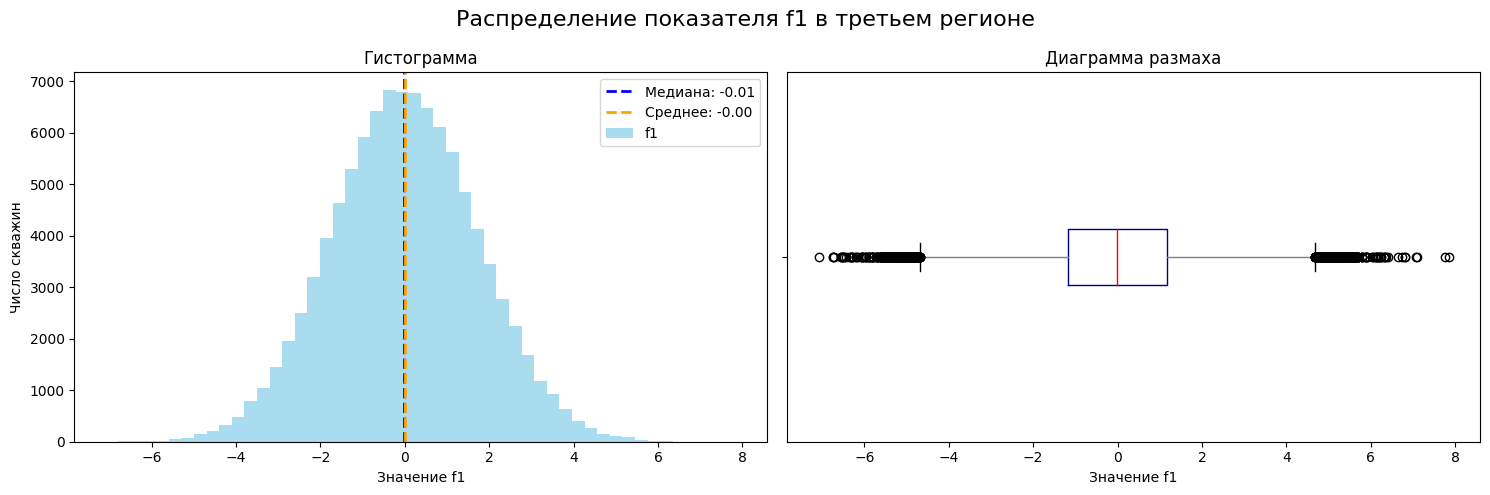

In [27]:
hist_and_box_chart(reg_3, 'f1', 'Распределение показателя f1 в третьем регионе', 'Число скважин', 'Значение f1', 50)

In [28]:
reg_3.query('(f1 < -4.5) | (f1 > 4.5)')

,id,f0,f1,f2,product
110,ByiA5,0.194230,-5.429406,8.430379,150.744572
279,lZsKI,-1.009853,4.592661,0.942551,54.416996
304,JPo2O,-2.658937,5.655811,2.218928,141.726290
314,LIwmP,0.577238,5.389690,-0.458313,140.980012
322,Wci7T,-2.537793,4.515745,-3.740523,105.275686
...,...,...,...,...,...
99233,FvfPt,1.530457,4.844400,2.421428,126.567042
99393,sdBoZ,0.486805,-5.201983,-2.235533,116.155874
99648,PNuY1,0.973961,5.148257,5.521346,162.870545
99714,NhiMu,0.923716,5.619497,-0.329068,147.824016


- Все три распределения разные: по форме, диапазону, средним значениям.
- Первый регион имеет очень компактный диапазон значений и достаточно равномерное распределение данных в рамках дипазона (с небольшими пиками). Выбросов нет. Среднее равно 0.25.
- Второй регион имеет самый большой диапазон значений с распределением, похожим на нормальное. Есть выбросы в обе стороны, но их число указывает скорее на то, что в ряде ситуации такие показатели ок. Среднее равно -4.8
- Третий регион имеет умеренный разброс и распределение, похожее на нормальное. Ситуация с выбросами - как во втором регионе: много в обе стороны, так что, скорее всего, это допустимые значения. Среднее похоже на первый регион - 0. 

### Анализ признака f2

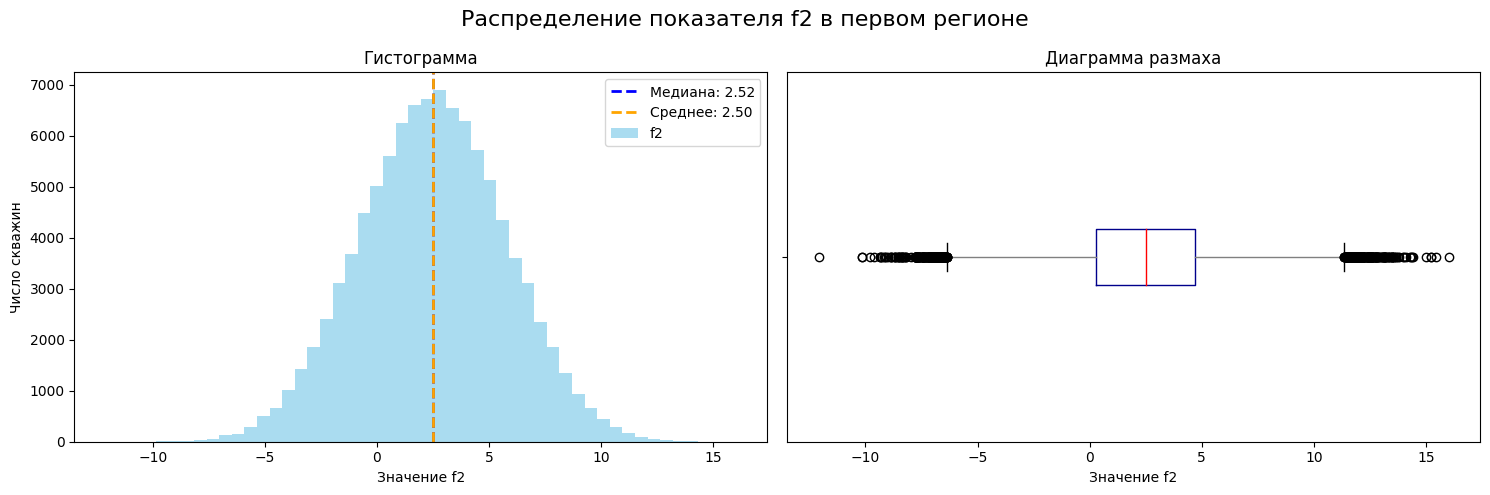

In [29]:
hist_and_box_chart(reg_1, 'f2', 'Распределение показателя f2 в первом регионе', 'Число скважин', 'Значение f2', 50)

In [30]:
reg_1.query('(f2 < -6) | (f2 > 11)')

,id,f0,f1,f2,product
131,hGDMF,-0.749902,0.654446,13.339420,130.648792
232,91Tg4,-0.403666,0.805531,-8.869885,46.546824
432,UAuJY,0.035181,0.999353,-6.159297,30.207315
457,RQPXf,0.099673,0.134502,-6.322886,88.248664
829,lOXZ8,0.924403,-0.032851,-6.080357,35.144155
...,...,...,...,...,...
99291,IAJQH,1.193736,-0.385367,-7.155326,106.118759
99388,Iias4,0.297242,-0.454613,11.534827,162.690385
99399,TePsR,0.651008,0.791712,11.682042,151.009229
99628,OEDcT,1.238443,-0.511931,12.585500,173.612787


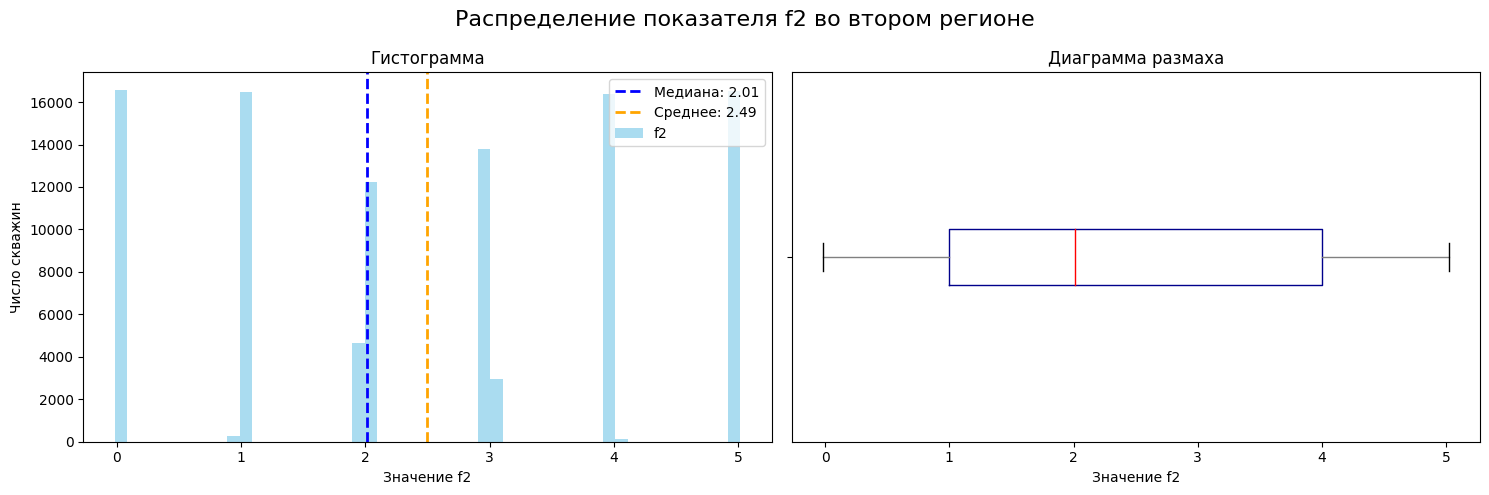

In [31]:
hist_and_box_chart(reg_2, 'f2', 'Распределение показателя f2 во втором регионе', 'Число скважин', 'Значение f2', 50)

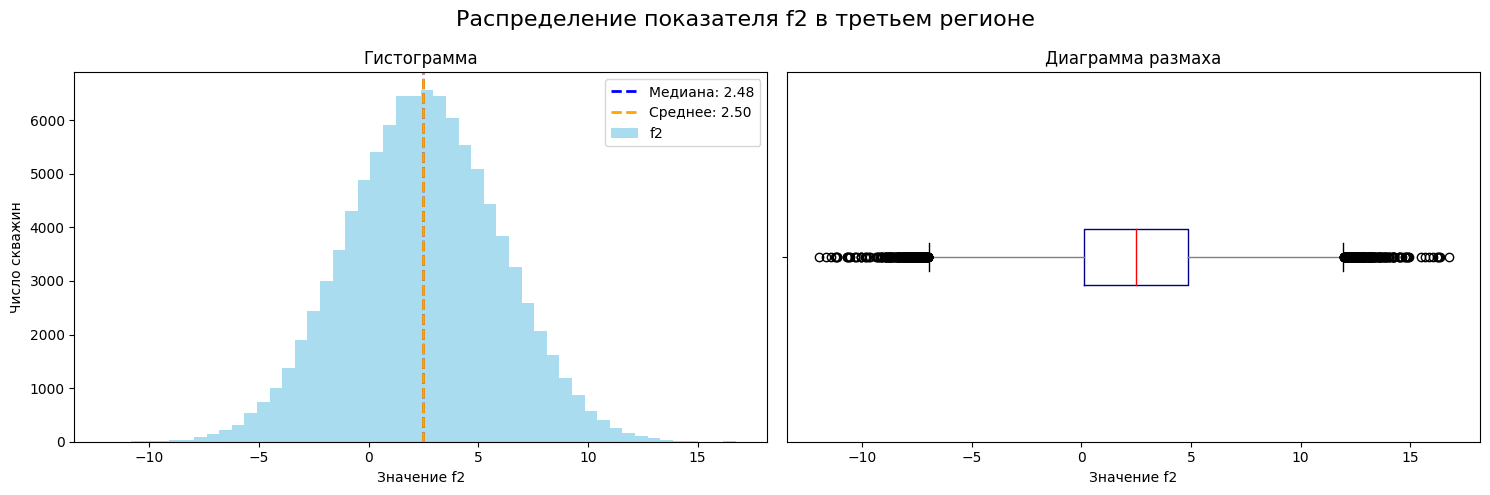

In [32]:
hist_and_box_chart(reg_3, 'f2', 'Распределение показателя f2 в третьем регионе', 'Число скважин', 'Значение f2', 50)

In [33]:
reg_3.query('(f2 < -6) | (f2 > 11)')

,id,f0,f1,f2,product
211,TYrYl,-0.876439,1.148639,-6.276067,26.199921
240,rNDro,-0.017153,3.775609,-7.522400,92.007364
241,kXacb,1.283423,-0.262485,11.288307,137.108925
303,oRCjP,-1.901541,2.434956,-6.155733,69.888288
319,XVb4t,-1.277953,-2.906498,-8.588589,89.531978
...,...,...,...,...,...
99553,xrnOj,1.228094,0.956760,-7.201436,33.036502
99580,kHIG1,1.395574,-0.827866,-7.217435,16.081916
99620,5kAL2,3.478260,1.842257,12.855746,163.258517
99632,91wmF,1.634638,0.648326,-6.050760,89.174701


- Распределение в первом и третьем регионах выглядят схоже: форма, похожая на нормальное распределение, среднее 2.5, диапазон значений от -10 до 15, одинаковые хвосты очень низких и высоких значений.
- Наличие "выбросов" в большом количестве в распределениях регионов один и три скорее указывает на то, что при определенных условиях такие значения более чем реальны-адекватны для некоторых типов скважин.
- Распределение во втором регионе выглядит почти искусственным: у данных диапазон ядра значений 1 и 3 региона от 0 до 5, а внутри - низкая вариативность и стабильный шаг в ~1, а также почти равное распределение на всем промежутке.

### Анализ оценки объема запасов нефти

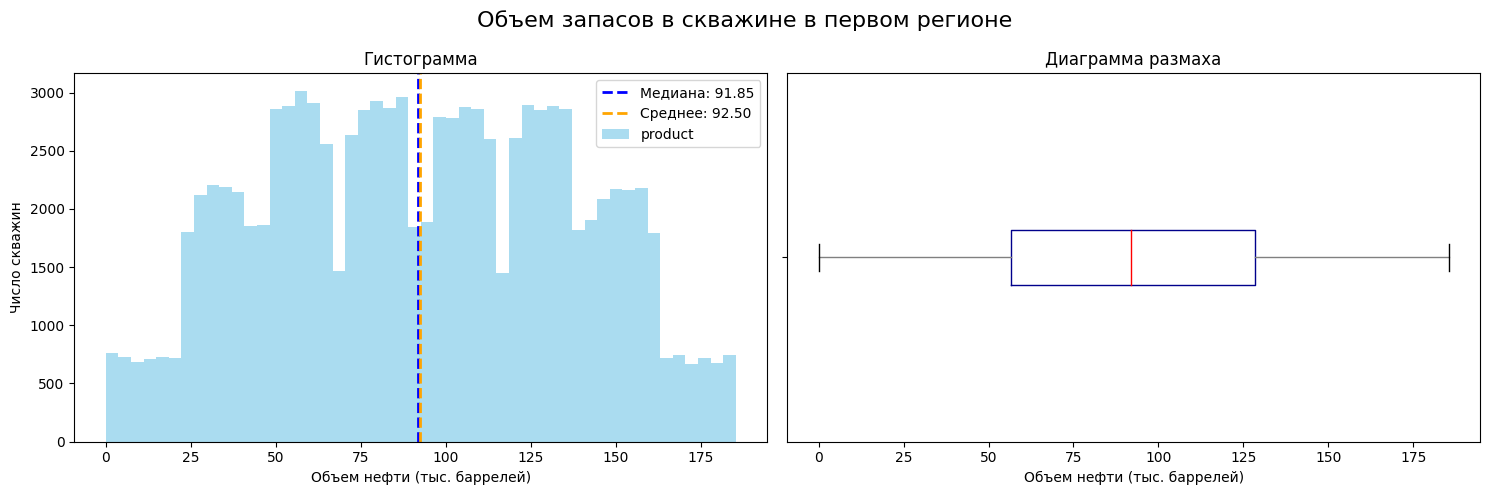

In [34]:
hist_and_box_chart(reg_1, 'product', 'Объем запасов в скважине в первом регионе', 'Число скважин', 'Объем нефти (тыс. баррелей)', 50)

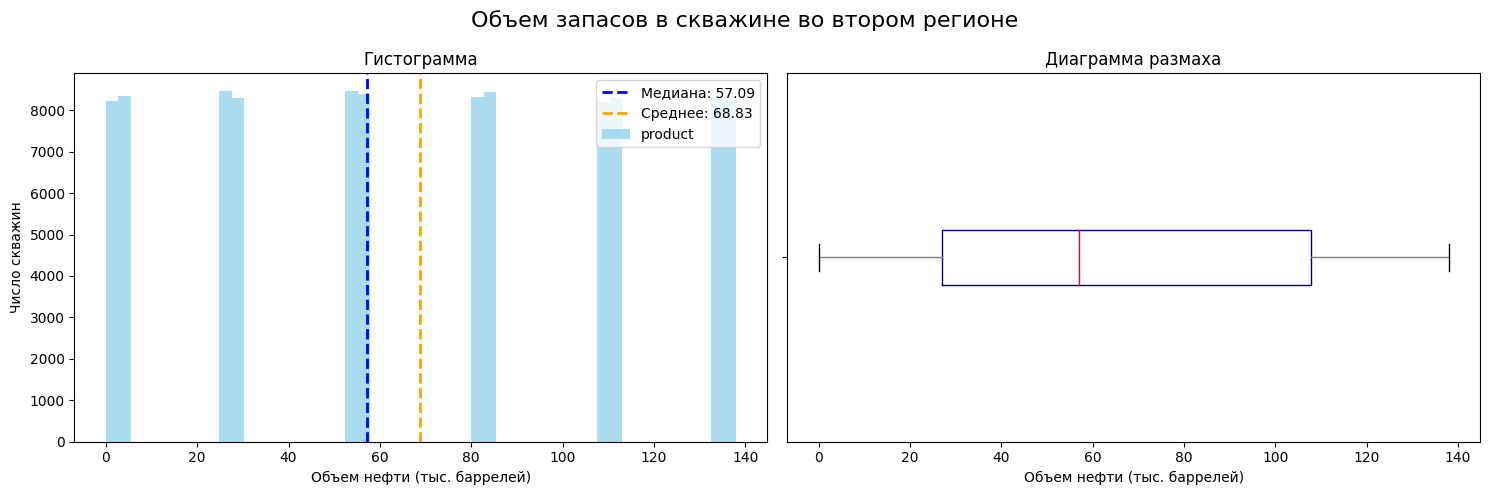

In [35]:
hist_and_box_chart(reg_2, 'product', 'Объем запасов в скважине во втором регионе', 'Число скважин', 'Объем нефти (тыс. баррелей)', 50)

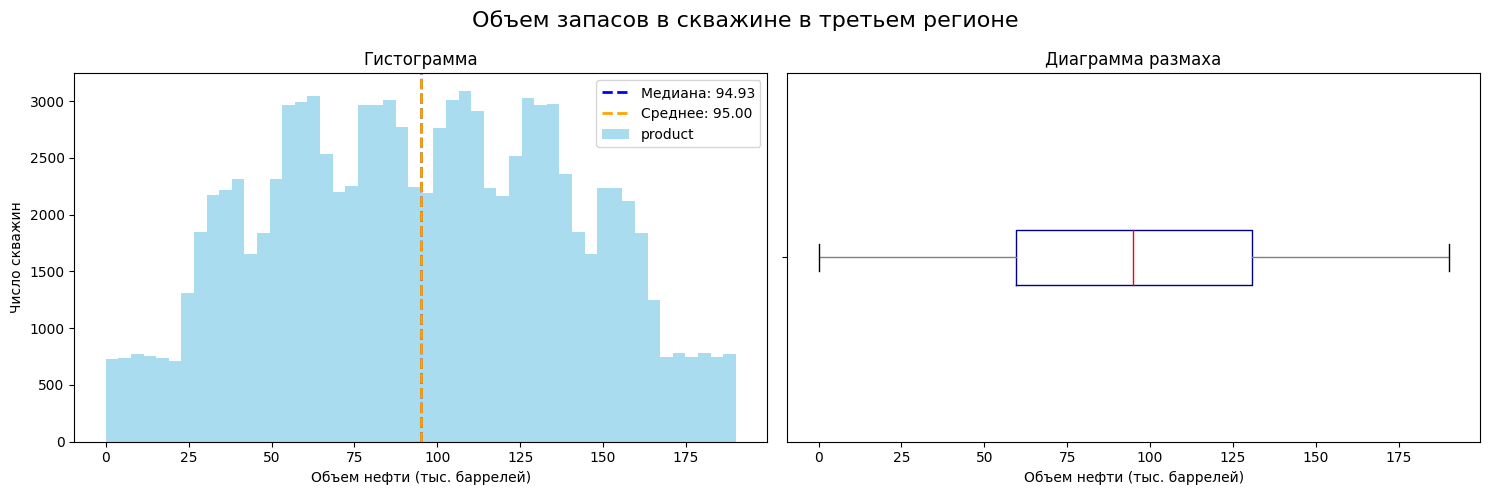

In [36]:
hist_and_box_chart(reg_3, 'product', 'Объем запасов в скважине в третьем регионе', 'Число скважин', 'Объем нефти (тыс. баррелей)', 50)

- Распределения в 1 и 3 регионе выглядят схоже: форма с более-менее равномерным (но с пиками) распределением между 30 и 160 с заметными спадами за пределами этих значений, среднее 92.5 и 95, диапазон от 0 до 180.
- Распределение во 2 регионе снова выглядит искусственным: у данных схожий диапазон, но внутри вариативность значений в разы ниже, имеет стабильный шаг в ~23 тыс., и распределение значений очень уж равное на всём промежутке.

### Выводы из исследовательского анализа данных

- Данные по признакам f0 и f1 заметно отличаются во всех трех регионах, особенно по форме распределений и по диапазону.
- Данные по признакам f2 и объему нефти очень схожи в первом и третьем регионах. Данные второго региона по этим признакам выглядят почти искусственно - у них очень странное распределение с малой вариативностью и равномерным шагом по всему диапазону (который тоже отличен от первого и третьего региона).
- Вероятно, во втором регионе могут быть какие-то трудности со сбором данных, связанные с техникой, человеческим фактором или другими проблемами доступности информации.

## Корреляционный анализ данных

- Т.к. для каждого региона будет строиться своя модель, то и корреляцию признаков мы будем смотреть отдельно по каждому региону.
- Посмотрим тепловую карту с корреляцией Пирсона, т.к. у нас все признаки числовые и модель линейная, и PhiK-матрицу на случай нелинейных связей.

### Первый регион

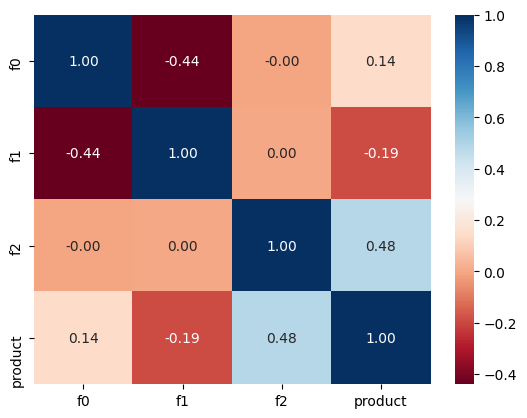

In [37]:
#построим тепловую карту
sns.heatmap(reg_1.drop('id', axis=1).corr(), annot=True, fmt='.2f', cmap='RdBu');

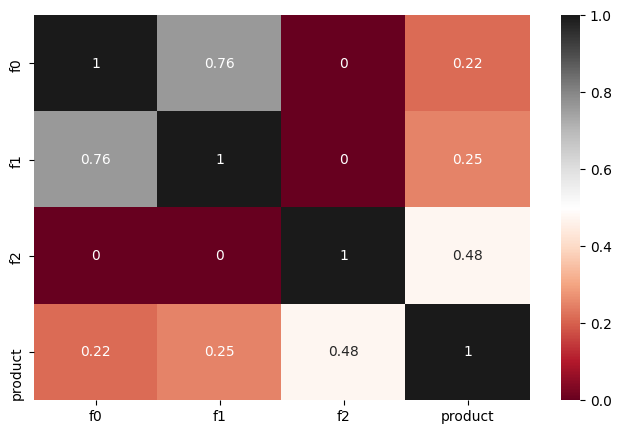

In [38]:
#построим PHIK-матрицу
plt.figure(figsize=(8, 5))
interval_cols = ['f0', 'f1', 'f2', 'product']
sns.heatmap(reg_1.drop('id', axis=1).phik_matrix(interval_cols=interval_cols), annot=True, cmap='RdGy');

- На обеих матрицах видно, что целевой признак умеренно коррелирует с f2.
- Корреляция с f0 и f1 на обеих матрицах очень слабая.
- Есть заметная корреляция между f1 и f0, но не критичная.

### Второй регион

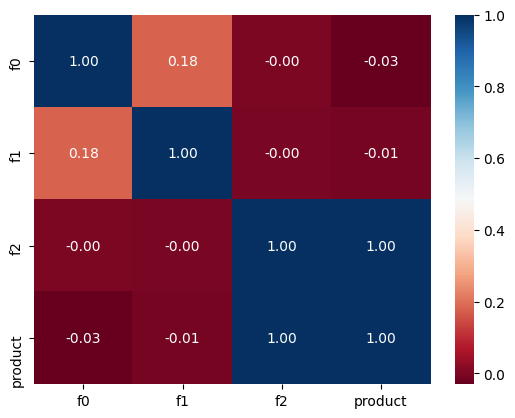

In [39]:
#построим тепловую карту
sns.heatmap(reg_2.drop('id', axis=1).corr(), annot=True, fmt='.2f', cmap='RdBu');

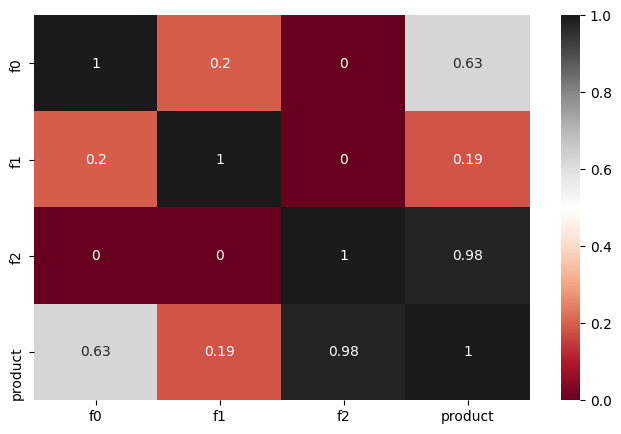

In [40]:
#построим PHIK-матрицу
plt.figure(figsize=(8, 5))
interval_cols = ['f0', 'f1', 'f2', 'product']
sns.heatmap(reg_2.drop('id', axis=1).phik_matrix(interval_cols=interval_cols), annot=True, cmap='RdGy');

- Обе матрицы указывают на сильнейшую линейную корреляцию f2 и целевого признака. Без контекста мы не можем определить такую корреляцию как утечку/не_утечку, поэтому будем считать это просто очень высокой корреляцией.
- Между f0 и целевым признаком также есть связь, но она нелинейная: коэффициент Пирсона близок к 0, а вот Phik высокий - 0.63.

### Третий регион

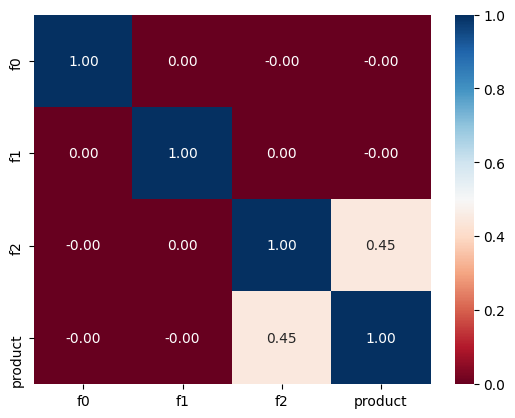

In [41]:
#построим тепловую карту
sns.heatmap(reg_3.drop('id', axis=1).corr(), annot=True, fmt='.2f', cmap='RdBu');

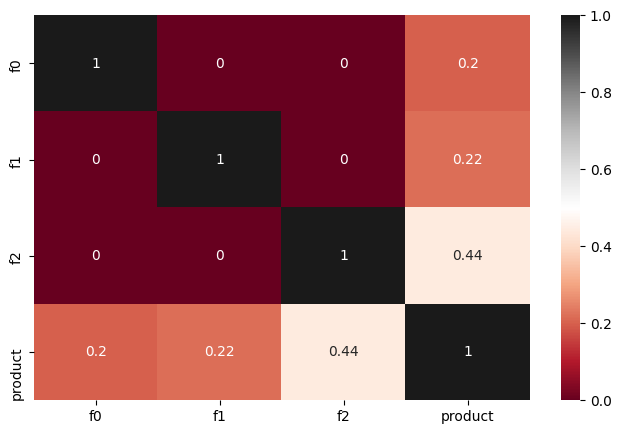

In [42]:
#построим PHIK-матрицу
plt.figure(figsize=(8, 5))
interval_cols = ['f0', 'f1', 'f2', 'product']
sns.heatmap(reg_3.drop('id', axis=1).phik_matrix(interval_cols=interval_cols), annot=True, cmap='RdGy');

- На обеих матрицах видно, что целевой признак умеренно коррелирует с f2.
- Корреляция с f0 и f1 на обеих матрицах очень слабая.

### Выводы из корреляционного анализа

- Во всех трех случаях целевой признак имел заметную корреляцию с целевым, а во втором регионе и вовсе 1 к 1 (но там и данные по f2 и целевому признаку имели очень математичный-искусственный вид).
- Во втором регионе также очень заметна нелинейная связь f0 и целевого признака, и коэффициент этой связи в 3 раза выше, чем в двух других регионах.
- Корреляция f1 и целевого признака везде незначительная.
- Мультиколинеарность не выявлена.

## Модель прогноза объемов запаса нефти

- Для каждого региона мы создадим модель линейной регрессии, чтобы предсказать в регионе объем запасов нефти.
- Целевой признак - объем запасов нефти, 'product'.
- В качестве предобработки масштабируем данные с помощью StandardScaler(). Пропусков и категориальных данных в датасетах нет, поэтому другая предобработка не требуется. 
- Метрика для оценки моделей - корень из средней квадратичной ошибки.
- Результаты предсказаний и соответствующие им реальные значения сохраним в таблице для дальнейшего анализа.

### Модель для первого региона

In [43]:
#создадим выборки и проверим размеренность
X_train_1, X_val_1, y_train_1, y_val_1 = train_val_selector(reg_1)

Размеренность тренеровочного и валидационного датасетов с входными признаками:(75000, 3) и (25000, 3)
Длина соответствующих столбцов с целевым значением: 75000 и 25000


In [44]:
#обучим модель и получим оценку объемов нефти в регионе
prediction_1 = linear_model_prediction (X_train_1, X_val_1, y_train_1, y_val_1)

Корень из средней квадратичной ошибки для модели 37.64

Среднее значение предсказанного объема запаса нефти в регионе: 92.77


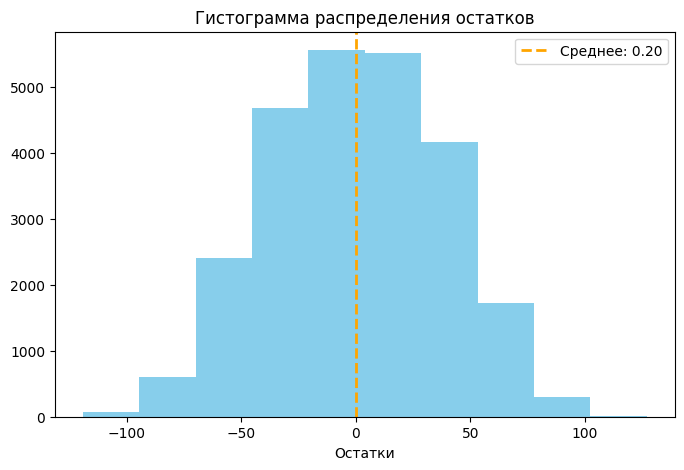

In [45]:
residuals_1 = y_val_1 - prediction_1

#построим графики для анализа остатков
plt.figure(figsize=(8, 5))
plt.hist(residuals_1, color = '#87CEEB')
plt.title('Гистограмма распределения остатков')
plt.xlabel('Остатки')
mean = residuals_1.mean()
plt.axvline(mean, color='orange', linestyle='dashed', linewidth=2, label=f'Среднее: {mean:.2f}')
plt.legend()

plt.show()

- Распределение остатков выглядит симметрично, среднее близко к 0. Модель не делает систематических ошибок в сторону завышения или занижения прогноза.
- Средняя погрешность - 37.64 тыс.баррелей.

In [46]:
#объединим оценку модели и фактические данные в единую таблицу для дальнейшей оценки рисков
reg_1_for_risk_analysys = pd.DataFrame({'product': y_val_1, 'product_prediction': prediction_1})
reg_1_for_risk_analysys

,product,product_prediction
65716,58.904731,52.644232
27857,174.444496,108.028618
55953,95.433245,83.907614
83660,93.363213,71.181027
17674,70.410739,111.219474
...,...,...
9893,165.251838,98.212882
41375,119.418244,73.383664
94435,66.211900,86.527385
74804,56.937502,138.355879


### Модель для второго региона

In [47]:
#создадим выборки и проверим размеренность
X_train_2, X_val_2, y_train_2, y_val_2 = train_val_selector(reg_2)

Размеренность тренеровочного и валидационного датасетов с входными признаками:(75000, 3) и (25000, 3)
Длина соответствующих столбцов с целевым значением: 75000 и 25000


In [48]:
#обучим модель и получим оценку объемов нефти в регионе
prediction_2 = linear_model_prediction (X_train_2, X_val_2, y_train_2, y_val_2)

Корень из средней квадратичной ошибки для модели 0.9

Среднее значение предсказанного объема запаса нефти в регионе: 68.64


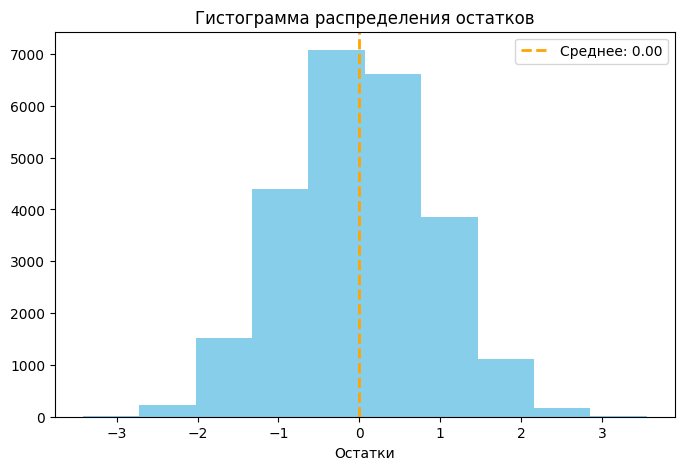

In [49]:
residuals_2 = y_val_2 - prediction_2

#построим графики для анализа остатков
plt.figure(figsize=(8, 5))
plt.hist(residuals_2, color = '#87CEEB')
plt.title('Гистограмма распределения остатков')
plt.xlabel('Остатки')
mean = residuals_2.mean()
plt.axvline(mean, color='orange', linestyle='dashed', linewidth=2, label=f'Среднее: {mean:.2f}')
plt.legend()

plt.show()

- Распределение остатков выглядит симметрично, среднее близко к 0. Модель не делает систематических ошибок в сторону завышения или занижения прогноза.
- Средняя погрешность - меньше 1 тыс. баррелей.

In [50]:
#объединим оценку модели и фактические данные в единую таблицу для дальнейшей оценки рисков
reg_2_for_risk_analysys = pd.DataFrame({'product': y_val_2, 'product_prediction': prediction_2})
reg_2_for_risk_analysys

,product,product_prediction
65716,3.179103,2.783121
27857,80.859783,81.485302
55953,107.813044,108.487750
83660,110.992147,111.686550
17674,30.132364,29.790434
...,...,...
9893,134.766305,135.016307
41375,137.945408,137.232445
94435,134.766305,134.142981
74804,0.000000,0.414021


### Модель для третьего региона

In [51]:
#создадим выборки и проверим размеренность
X_train_3, X_val_3, y_train_3, y_val_3 = train_val_selector(reg_3)

Размеренность тренеровочного и валидационного датасетов с входными признаками:(75000, 3) и (25000, 3)
Длина соответствующих столбцов с целевым значением: 75000 и 25000


In [52]:
#обучим модель и получим оценку объемов нефти в регионе
prediction_3 = linear_model_prediction (X_train_3, X_val_3, y_train_3, y_val_3)

Корень из средней квадратичной ошибки для модели 40.28

Среднее значение предсказанного объема запаса нефти в регионе: 95.08


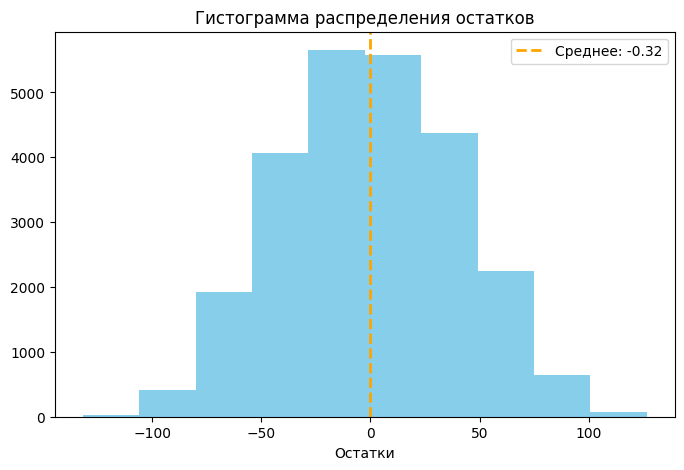

In [53]:
residuals_3 = y_val_3 - prediction_3

#построим графики для анализа остатков
plt.figure(figsize=(8, 5))
plt.hist(residuals_3, color = '#87CEEB')
plt.title('Гистограмма распределения остатков')
plt.xlabel('Остатки')
mean = residuals_3.mean()
plt.axvline(mean, color='orange', linestyle='dashed', linewidth=2, label=f'Среднее: {mean:.2f}')
plt.legend()

plt.show()

- Распределение остатков выглядит симметрично, среднее близко к 0. Модель не делает систематических ошибок в сторону завышения или занижения прогноза.
- Средняя погрешность - 40.3 тыс. баррелей.

In [54]:
#объединим оценку модели и фактические данные в единую таблицу для дальнейшей оценки рисков
reg_3_for_risk_analysys = pd.DataFrame({'product': y_val_3, 'product_prediction': prediction_3})
reg_3_for_risk_analysys

,product,product_prediction
65716,104.287591,65.870320
27857,89.156753,81.345498
55953,41.278178,77.811517
83660,29.528634,89.847255
17674,74.243791,85.825481
...,...,...
9893,80.939834,96.315453
41375,44.952689,93.575376
94435,78.620859,71.214414
74804,138.295700,112.036526


### Выводы по моделям прогноза запасов

**Первый регион**:
- **Предсказуемость**: Модель в среднем ошибается на 37.6 тыс баррелей. Это второй лучший результат.
- **Запасы**: Среднее значение предсказанного объема запасов нефти в регионе - 92.8 тыс. баррелей. Это также второй лучший результат.
_____

**Второй регион**:
- **Предсказуемость**: Модель в среднем ошибается на 0.9 тыс баррелей. Это лучший результат. (Впрочем, он может быть обусловлен не совсем корректными данными.)
- **Запасы**: Среднее значение предсказанного объема запасов нефти в регионе - 68.6 тыс. баррелей. Это худший результат, он на 28% хуже самого лучшего.
______

**Третий регион**:
- **Предсказуемость**: Модель в среднем ошибается на 40.3 тыс баррелей. Это худший результат. Однако, он в целом схож с моделью первого региона.
- **Запасы**: Среднее значение предсказанного объема запасов нефти в регионе - 95 тыс. баррелей. Это самый высокий показатель.

## Рассчет рисков и прибыли

Для оценки потенциала региона мы сделаем следующее:
- Найдем точку безубыточности - среднее значение объема запаса нефти в скважине для безубыточного производства.
- Сравним точку безубыточности со средним показателем в регионе.
- Проведем оценку потенциальной доходности каждого региона при разработке топ-200 самых перспективных скважин согласно предсказаниям модели.

### Точка безубыточности

In [55]:
#бюджет на разработку скважин в регионе
BUDGET = 10000000000

#количество исследуемых точек при разведке
POINTS_TO_RESEARCH = 500 

#количество точек для разработки 
POINTS_TO_CHOOSE = 200 

#цена за 1000 баррелей, т.к. данные в таблице - в тысячах баррелей
PRICE_PER_1K = 1000 * 450

#максимально допустимая вероятность убытков
MAX_LOSS = 0.025

In [56]:
#рассчитаем точку безубыточности - среднее значение объемов скважины для безубыточной добычи
MIN_PRODUCT_PER_POINT = (BUDGET/POINTS_TO_CHOOSE)/PRICE_PER_1K
print('Среднее значение объема запаса нефти в скважине для безубыточного производства:', round(MIN_PRODUCT_PER_POINT, 2))
print('')
print('Первый регион:')
print('Среднее значение предсказанного объема запаса нефти в регионе:', round(reg_1_for_risk_analysys['product_prediction'].mean(), 2))
print('Среднее значение реального объема запаса нефти в регионе:', round(reg_1_for_risk_analysys['product'].mean(), 2))
print('Среднее значение топ-200 скважин, согласно прогнозу:', round(reg_1_for_risk_analysys.sort_values(by='product_prediction', ascending=False)['product_prediction'].head(200).mean(), 2))
print('')
print('Второй регион:')
print('Среднее значение предсказанного объема запаса нефти в регионе:', round(reg_2_for_risk_analysys['product_prediction'].mean(), 2))
print('Среднее значение реального объема запаса нефти в регионе:', round(reg_2_for_risk_analysys['product'].mean(), 2))
print('Среднее значение топ-200 скважин, согласно прогнозу:', round(reg_2_for_risk_analysys.sort_values(by='product_prediction', ascending=False)['product_prediction'].head(200).mean(), 2))
print('')
print('Третий регион:')
print('Среднее значение предсказанного объема запаса нефти в регионе:', round(reg_3_for_risk_analysys['product_prediction'].mean(), 2))
print('Среднее значение реального объема запаса нефти в регионе:', round(reg_3_for_risk_analysys['product'].mean(), 2))
print('Среднее значение топ-200 скважин, согласно прогнозу:', round(reg_3_for_risk_analysys.sort_values(by='product_prediction', ascending=False)['product_prediction'].head(200).mean(), 2))



Среднее значение объема запаса нефти в скважине для безубыточного производства: 111.11

Первый регион:
Среднее значение предсказанного объема запаса нефти в регионе: 92.77
Среднее значение реального объема запаса нефти в регионе: 92.98
Среднее значение топ-200 скважин, согласно прогнозу: 154.78

Второй регион:
Среднее значение предсказанного объема запаса нефти в регионе: 68.64
Среднее значение реального объема запаса нефти в регионе: 68.64
Среднее значение топ-200 скважин, согласно прогнозу: 138.72

Третий регион:
Среднее значение предсказанного объема запаса нефти в регионе: 95.08
Среднее значение реального объема запаса нефти в регионе: 94.76
Среднее значение топ-200 скважин, согласно прогнозу: 149.51


- Значение запаса нефти в скважине для безубыточной добычи сейчас выше среднего по всем регионам. Минимум на 16 тысяч - в сравнении с третьим регионом.
- Однако, для всех трех регионов среднее значение для безубыточной добычи заметно ниже среднего среди 200 самых перспективных скважин, согласно прогнозу. Минимум на 27 тысяч - в сравнении со вторым регионом.
- Дальнейший анализ мы сфокусируем на том, насколько приемлемым является качество прогноза топ-200 с точки зрения финансовых показателей.

### Анализ рисков при разработке на основе прогноза

In [57]:
#оценим потенциал прибыли и рисков первого региона
profit_mean_1, profit_lower_1, profit_upper_1, loss_probability_1 = profit_variations(reg_1_for_risk_analysys)

Среднее значение доходности при разработке топ-200 из 500 скважин в регионе: 483167794.55
95% доверительный интервал: (-28817847.17, 958042963.49)
Вероятность убытков равна 0.03, что больше чем максимальная допустимая вероятность 0.025


In [58]:
#оценим потенциал прибыли и рисков первого региона
profit_mean_2, profit_lower_2, profit_upper_2, loss_probability_2 = profit_variations(reg_2_for_risk_analysys)

Среднее значение доходности при разработке топ-200 из 500 скважин в регионе: 446328247.85
95% доверительный интервал: (31054171.82, 842478985.18)
Вероятность убытков равна 0.017, что меньше чем максимальная допустимая вероятность 0.025


In [59]:
#оценим потенциал прибыли и рисков первого региона
profit_mean_3, profit_lower_3, profit_upper_3, loss_probability_3 = profit_variations(reg_3_for_risk_analysys)

Среднее значение доходности при разработке топ-200 из 500 скважин в регионе: 315433432.42
95% доверительный интервал: (-188067752.19, 828388665.33)
Вероятность убытков равна 0.119, что больше чем максимальная допустимая вероятность 0.025


In [60]:
profit_variations_data = pd.DataFrame({'region': ['Первый регион', 'Второй регион', 'Третий регион'], 
                              'profit_mean': [profit_mean_1, profit_mean_2, profit_mean_3],
                              '95_conf_interval_lower': [profit_lower_1, profit_lower_2, profit_lower_3],
                              '95_conf_interval_upper': [profit_upper_1, profit_upper_2, profit_upper_3],
                              'loss_probability': [loss_probability_1, loss_probability_2, loss_probability_3]})
profit_variations_data

,region,profit_mean,95_conf_interval_lower,95_conf_interval_upper,loss_probability
0,Первый регион,4.831678e+08,-2.881785e+07,9.580430e+08,0.030
1,Второй регион,4.463282e+08,3.105417e+07,8.424790e+08,0.017
2,Третий регион,3.154334e+08,-1.880678e+08,8.283887e+08,0.119


- Вероятность убытков меньше всего во втором регионе - 1.7%. Это также единственный регион, где вероятность убытков не превышает допустимое значение.
- Самый предсказуемый, компактный доверительный интервал во втором регион - от 31 054 171.82 до 842 478 985.18. Это также единственный регион без отрицательных значений на нижней границе доверительного интервала.
- Самое высокое среднее значение доходности в первом регионе - 483 167 794.55. Верхняя граница доверительного интервала там также заметно выше, чем во втором и третьем.

### Выводы по рассчетам рисков и прибыли

**Вероятность убытков**
- Минимальное значение вероятности убытков во втором регионе - 1.7%. Это также единственный регион, где вероятность убытков не превышает допустимое значение.
- Второй регион незначительно превышает допустимое значение вероятности убытков - там вероятность убытков 3%, что на 0.5% выше допустимого.
______

**Диапазон прогнозируемой прибыли**
- Самый предсказуемый, компактный 95% доверительный интервал прогнозов прибыли во втором регионе - от 31054171.8196517 до 842478985.1824985. Это также единственный регион без отрицательных значений на нижней границе.
_____

**Среднее прогнозируемое значение доходности**
- Самое высокое среднее прогнозируемое значение доходности в первом регионе - 483 167 794.55. Верхняя граница доверительного интервала там также заметно выше, чем во втором и третьем.
______

**По результатам исследования рисков и прибыли рекомендуются разработки во Втором регионе.**

Однако, первый регион может быть также рассмотрен, т.к. риск потерь очень незначительно отличается от допустимого, а прибыли выше и исходные данные выглядят достовернее.

## Общие выводы

**Ход проекта**

1. **Обзор и предобработка данных**
   - В целом в данных не выявлено значительных недостатков.
   - Были выявлены дубликаты в столбце id (10 в первом регионе и по 4 во втором и третьем). Сами строки-дубликаты выглядят нормально и не схожи между собой, поэтому ошибка вероятнее всего в заполнении id. Т.к. id использоваться не будет, строки для исследования оставили.
2. **Исследовательский анализ данных**
   - Данные по признакам f0 и f1 заметно отличаются во всех трех регионах, особенно по форме распределений и по диапазону.
   - Данные по признакам f2 и объему нефти очень схожи в первом и третьем регионах. Данные второго региона по этим признакам выглядят почти искусственно - у них очень странное распределение с малой вариативностью и равномерным шагом по всему диапазону (который тоже отличен от первого и третьего региона).
   - Вероятно, во втором регионе могут быть какие-то трудности со сбором данных, связанные с техникой, человеческим фактором или другими проблемами доступности информации.
3. **Корреляционный анализ**
   - Во всех трех случаях целевой признак имел заметную корреляцию с целевым, а во втором регионе и вовсе 1 к 1 (но там и данные по f2 и целевому признаку имели очень математичный-искусственный вид).
   - Во втором регионе также очень заметна нелинейная связь f0 и целевого признака, и коэффициент этой связи в 3 раза выше, чем в двух других регионах.
   - Корреляция f1 и целевого признака везде незначительная.
   - Мультиколинеарность не выявлена.
4. **Обучение моделей прогноза запасов нефти для каждого региона**
   - **Модель Первого региона:**
     1) Предсказуемость: Модель в среднем ошибается на 37.6 тыс баррелей. Это второй лучший результат.
     2) Запасы: Среднее значение предсказанного объема запасов нефти в регионе - 92.8 тыс. баррелей. Это также второй лучший результат.
   - **Модель Второго региона:**
     1) Предсказуемость: Модель в среднем ошибается на 0.9 тыс баррелей. Это лучший результат. (Впрочем, он может быть обусловлен не совсем корректными данными.)
     2) Запасы: Среднее значение предсказанного объема запасов нефти в регионе - 68.6 тыс. баррелей. Это худший результат, он на 28% хуже самого лучшего.
   - **Модель Третьего региона:**
     1) Предсказуемость: Модель в среднем ошибается на 40.3 тыс баррелей. Это худший результат. Однако, он в целом схож с моделью первого региона.
     2) Запасы: Среднее значение предсказанного объема запасов нефти в регионе - 95 тыс. баррелей. Это самый высокий показатель.
5. **Анализ рисков и прибыли при разработке на основе прогнозов моделей**
   - **Вероятность убытков**
     1) Минимальное значение вероятности убытков во втором регионе - 1.7%. Это также единственный регион, где вероятность убытков не превышает допустимое значение.
     2) Второй регион незначительно превышает допустимое значение вероятности убытков - там вероятность убытков 3%, что на 0.5% выше допустимого.
   - **Диапазон прогнозируемой прибыли**
     1) Самый предсказуемый, компактный 95% доверительный интервал прогнозов прибыли во втором регионе - от 31 054 171.82 до 842 478 985.18. Это также единственный регион без отрицательных значений на нижней границе.
   - **Среднее прогнозируемое значение доходности**
     1) Самое высокое среднее прогнозируемое значение доходности в первом регионе - 483167794.55. Верхняя граница доверительного интервала там также заметно выше, чем во втором и третьем.
_______

**По результатам исследования имеющихся данных рекомендуются разработки во Втором регионе.**

- Данный регион имеет минимальное значение вероятности убытков 1.7%.
- 95% доверительный интервал вероятной прибыли компактный, предсказуемый и без отрицательных значений на нижней границе.
- Разница среднего прогнозируемого значения с регионе отличается от максимального из трех регионов только на 37 миллионов, что не много, учитывая масштаб сумм.
_______

**Первый регион может быть рассмотрен как альтернативный вариант.**

- Данный регион имеет риск потерь 3%, выше допустимого на 0.5%.
- В регионе самое высокое значение средней прибыли и значительно более высокое значение на верхней нижней границе доверительного интервала.
_______

**Рекомендуется дополнительная проверка и сбор информации.**

- Ряд наблюдений по Второму региону выглядит несколько сомнительно в контексте аналогичных данных по Первому и Третьему региону.
- Дополнительные данные по всем регионам позволят улучшить модели прогноза объемов нефти в регионе, а значит и точность прогнозов выручки.